In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)

In [2]:
# Download BTC-USD data with daily interval
btc_data = yf.download('BTC-USD', start='2018-01-01', end='2024-04-01', interval='1d')
btc_data = btc_data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [3]:
# Calculate moving averages (10 and 50 periods)
btc_data['MA10'] = btc_data['Close'].rolling(window=10).mean()
btc_data['MA50'] = btc_data['Close'].rolling(window=50).mean()

In [4]:
# Define the strategy
btc_data['Signal'] = 0
btc_data['Signal'][50:] = np.where(btc_data['MA10'][50:] > btc_data['MA50'][50:], 1, -1)
btc_data['Position'] = btc_data['Signal'].shift()

In [5]:
# Calculate returns
btc_data['Return'] = btc_data['Close'].pct_change()
btc_data['StrategyReturn'] = btc_data['Return'] * btc_data['Position']
btc_data['CumulativeBuyHoldReturn'] = (1 + btc_data['Return']).cumprod()
btc_data['CumulativeStrategyReturn'] = (1 + btc_data['StrategyReturn']).cumprod()

In [6]:
# Split the data into train and test sets
train_data = btc_data.loc['2018-01-01':'2021-01-01']
test_data = btc_data.loc['2021-01-02':'2024-04-01']

In [7]:
# Calculate cumulative returns for train and test sets
train_cumulative_return_bh = train_data['CumulativeBuyHoldReturn'].iloc[-1]
train_cumulative_return_strategy = train_data['CumulativeStrategyReturn'].iloc[-1]
test_cumulative_return_bh = test_data['CumulativeBuyHoldReturn'].iloc[-1]
test_cumulative_return_strategy = test_data['CumulativeStrategyReturn'].iloc[-1]

In [8]:
# Calculate Sharpe ratio
train_sharpe_ratio = train_data['StrategyReturn'].mean() / train_data['StrategyReturn'].std()
test_sharpe_ratio = test_data['StrategyReturn'].mean() / test_data['StrategyReturn'].std()

# Calculate drawdown
train_drawdown = (train_data['CumulativeStrategyReturn'] / train_data['CumulativeStrategyReturn'].cummax() - 1).min()
test_drawdown = (test_data['CumulativeStrategyReturn'] / test_data['CumulativeStrategyReturn'].cummax() - 1).min()

In [9]:
# Calculate win-loss ratio
train_wl_ratio = (train_data['StrategyReturn'] > 0).sum() / (train_data['StrategyReturn'] < 0).sum()
test_wl_ratio = (test_data['StrategyReturn'] > 0).sum() / (test_data['StrategyReturn'] < 0).sum()

# Calculate maximum consecutive wins/losses
train_consecutive_wins = train_data['StrategyReturn'].gt(0).groupby((train_data['StrategyReturn'].gt(0) != train_data['StrategyReturn'].gt(0).shift()).cumsum()).cumsum().max()
train_consecutive_losses = train_data['StrategyReturn'].lt(0).groupby((train_data['StrategyReturn'].lt(0) != train_data['StrategyReturn'].lt(0).shift()).cumsum()).cumsum().max()
test_consecutive_wins = test_data['StrategyReturn'].gt(0).groupby((test_data['StrategyReturn'].gt(0) != test_data['StrategyReturn'].gt(0).shift()).cumsum()).cumsum().max()
test_consecutive_losses = test_data['StrategyReturn'].lt(0).groupby((test_data['StrategyReturn'].lt(0) != test_data['StrategyReturn'].lt(0).shift()).cumsum()).cumsum().max()

In [10]:
# Print results
print(f'Train Cumulative Return (Buy & Hold): {train_cumulative_return_bh}')
print(f'Train Cumulative Return (Strategy): {train_cumulative_return_strategy}')
print(f'Test Cumulative Return (Buy & Hold): {test_cumulative_return_bh}')
print(f'Test Cumulative Return (Strategy): {test_cumulative_return_strategy}')
print(f'Train Sharpe Ratio: {train_sharpe_ratio}')
print(f'Test Sharpe Ratio: {test_sharpe_ratio}')
print(f'Train Drawdown: {train_drawdown}')
print(f'Test Drawdown: {test_drawdown}')
print(f'Train Win-Loss Ratio: {train_wl_ratio}')
print(f'Test Win-Loss Ratio: {test_wl_ratio}')
print(f'Train Maximum Consecutive Wins: {train_consecutive_wins}')
print(f'Train Maximum Consecutive Losses: {train_consecutive_losses}')
print(f'Test Maximum Consecutive Wins: {test_consecutive_wins}')
print(f'Test Maximum Consecutive Losses: {test_consecutive_losses}')

Train Cumulative Return (Buy & Hold): 2.0749732653226456
Train Cumulative Return (Strategy): 2.2985343678979286
Test Cumulative Return (Buy & Hold): 5.038967991096112
Test Cumulative Return (Strategy): 6.718694690676734
Train Sharpe Ratio: 0.03878969102900567
Test Sharpe Ratio: 0.04372429071683534
Train Drawdown: -0.6382953001086973
Test Drawdown: -0.5115731117396518
Train Win-Loss Ratio: 1.0569744597249509
Test Win-Loss Ratio: 1.018739352640545
Train Maximum Consecutive Wins: 8
Train Maximum Consecutive Losses: 8
Test Maximum Consecutive Wins: 8
Test Maximum Consecutive Losses: 9


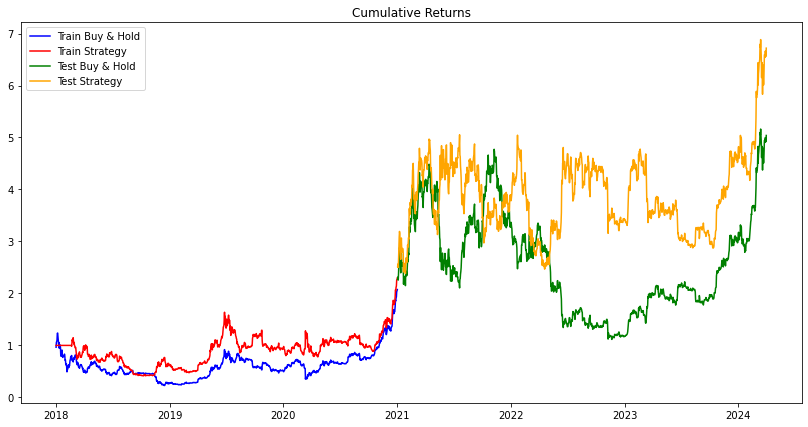

In [11]:
# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(train_data['CumulativeBuyHoldReturn'], label='Train Buy & Hold', color='blue')
plt.plot(train_data['CumulativeStrategyReturn'], label='Train Strategy', color='red')
plt.plot(test_data['CumulativeBuyHoldReturn'], label='Test Buy & Hold', color='green')
plt.plot(test_data['CumulativeStrategyReturn'], label='Test Strategy', color='orange')
plt.legend()
plt.title('Cumulative Returns')
plt.show()